In [ ]:
################################################################################################################
# Author:Animesh Kumar Paul(animeshk@ualberta.ca)                                                              #
# Special thanks to Andy for sharing the tolerance interval code                                               #
#                                                                                                              #                                                          #
################################################################################################################

In [9]:
import numpy as np
import pandas as pd
import pickle
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.lines import Line2D
from scipy.stats import sem
from numba import objmode, jit
from scipy.stats import binom

In [10]:
def load_path_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
###Added: 1.96 value taken from https://www.westga.edu/academics/research/vrc/assets/docs/confidence_intervals_notes.pdf
def confidenceInterval(mean, stderr, runs):
    #return (mean - 1.96 * stderr, mean + 1.96 * stderr)
    if runs==30:
        return (mean - 2.045 * stderr, mean + 2.045 * stderr) # for 30
    else:
        return (mean - 2.145 * stderr, mean + 2.145 * stderr) #for 15

In [12]:
###Tolerance Interval

def ppf(n: int, alpha: float, beta: float):
    return binom.ppf(1 - alpha, n, beta)

def getToleranceIndices(n: int, alpha: float, beta: float):
    # we cannot jit compile most things from scipy.stats
    # so perform a callback to the python interpreter to obtain this value
    y = 0.
    with objmode(y='float64'):
        y = ppf(n, alpha, beta)

    nu = int(n - y)

    # figure out indices
    if nu % 2 == 0:
        l = int(nu/2)
        u = int(n - (nu/2)) - 1
    else:
        nu1 = (nu/2) - (1/2)
        l = int(nu1)
        u = int(n - (nu1 + 1))

    return l, u

def toleranceIntervalOverCurve(data: np.ndarray, alpha=0.05, beta=0.9):
    n = data.shape[0]

    l, u = getToleranceIndices(n, alpha, beta)
    print(l, u)

    out = np.zeros((3, data.shape[1]))
    for i in range(data.shape[1]):
        d = np.sort(data[:, i])
        out[0, i] = d[l]
        out[1, i] = np.mean(data[:, i])
        out[2, i] = d[u]

    return out

In [19]:
col = ['#DE970B','#0D47A1','#3E2723','#E53935','#2E7D32','#AB47BC']

In [20]:
data_path = r'C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting'
plots_path = r'.\results\Plots'

In [21]:
replay_frequency_list = [1,2,4,8,16,32]
total_steps = 250000
fsize = 40

### Confidence Interval - Runs 30

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_1.pkl
Total Runs:  30
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_2.pkl
Total Runs:  30
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_4.pkl
Total Runs:  30
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_8.pkl
Total Runs:  30
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_16.pkl
Total Runs:  30
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_32.pkl
Total Runs:  30


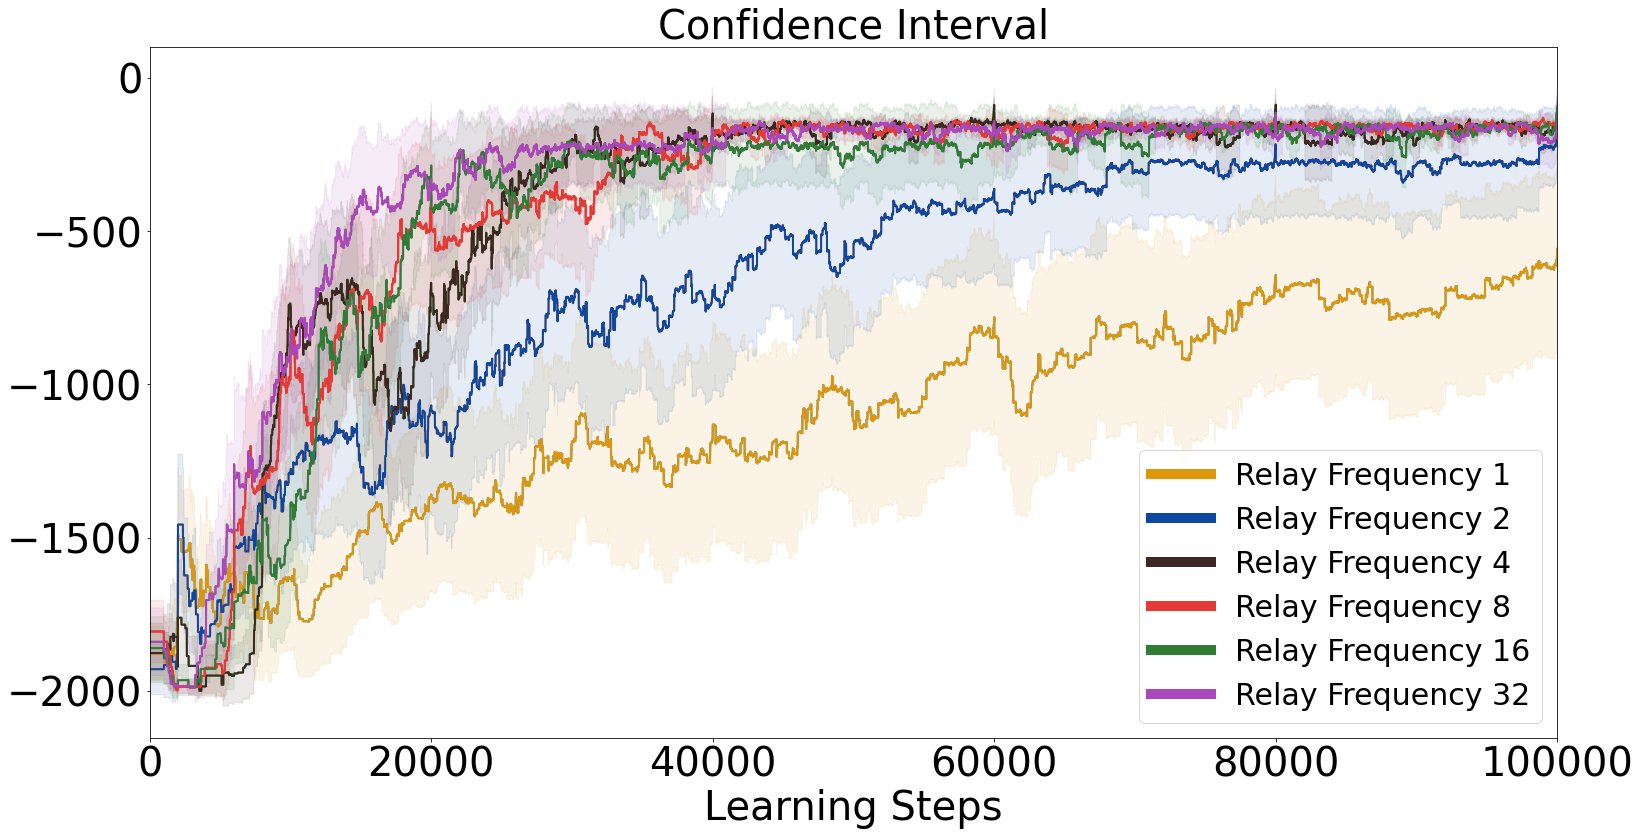

In [23]:
pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Confidence Interval_runs_30.pdf")
fig, ax = plt.subplots(figsize=(23,12))

for i, replay in enumerate(replay_frequency_list):
    path_file = data_path + "\log_train_rf_" + str(replay) + '.pkl'
    print(path_file)
    log_train = load_path_obj(path_file)
    log_train_EpisodeReturn = log_train[log_train['Metric']=="EpisodeReturns"].reset_index(drop=True)
    total_runs = np.unique(log_train_EpisodeReturn['Run']).shape[0]
    print('Total Runs: ', str(total_runs))
    episodic_return = np.zeros((total_runs, total_steps))
    #print(episodic_return)

    for r in range(total_runs):
        log_train_EpisodeReturn_PerRun = log_train_EpisodeReturn[log_train_EpisodeReturn['Run']==r+1].reset_index(drop=True)
        single_run_history = np.zeros(total_steps)
        previous_position = 0

        for e in range(log_train_EpisodeReturn_PerRun['Run'].shape[0]):
            temp = np.full((1, log_train_EpisodeReturn_PerRun['Step'][e] - previous_position), log_train_EpisodeReturn_PerRun['Undiscount_Return'][e])

            np.put(single_run_history, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e]),temp)
            previous_position = log_train_EpisodeReturn_PerRun['Step'][e]

        episodic_return[r]= single_run_history
        

    #Confidence Interval
    mean = np.mean(episodic_return,axis=0)
    ste = sem(episodic_return,axis=0)

    base, = ax.plot(mean, label=None, linewidth=2)
    (low_ci, high_ci) = confidenceInterval(mean, ste, total_runs)
    p1 = ax.fill_between(range(mean.shape[0]), low_ci, high_ci, color = col[i], alpha=0.10)
    p2 = ax.plot(range(mean.shape[0]), mean, linewidth=2, color = col[i], label ='Relay Frequency '+ str(replay) )



legend = plt.legend(loc=4,prop={'size': fsize},frameon=True)
legend_elements = [Line2D([0],[0],markersize=10,color=col[0],label='Relay Frequency 1', lw=10),
                   Line2D([0],[0],markersize=12,color=col[1],label='Relay Frequency 2', lw=10),
                   Line2D([0],[0],markersize=12,color=col[2],label='Relay Frequency 4', lw=10),
                   Line2D([0],[0],markersize=12,color=col[3],label='Relay Frequency 8', lw=10),
                   Line2D([0],[0],markersize=12,color=col[4],label='Relay Frequency 16', lw=10),
                   Line2D([0],[0],markersize=12,color=col[5],label='Relay Frequency 32', lw=10)]

ax.legend(handles=legend_elements,loc=4, prop={'size': 30})

#ax.legend(custom_lines)
plt.title('Confidence Interval',size = fsize)
#plt.xlabel("X axis label")
plt.xlabel("Learning Steps",size = fsize)
plt.tight_layout()
plt.subplots_adjust(left=0.10, right=0.95, top=0.9, bottom=0.1)
plt.xticks(size = fsize)
plt.yticks(size = fsize)
plt.xlim([0, 100000])
plt.show()

plt.close()
pdf.savefig(fig )
pdf.close()

### Tolerance Interval - Runs 30

C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_1.pkl
0 29
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_2.pkl
0 29
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_4.pkl
0 29
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_8.pkl
0 29
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_16.pkl
0 29
C:\Users\anime\UofA\Thesis\RL\Adam_UofA\Project\CMPUT_655_project_results_shared_folder\plotting\log_train_rf_32.pkl
0 29


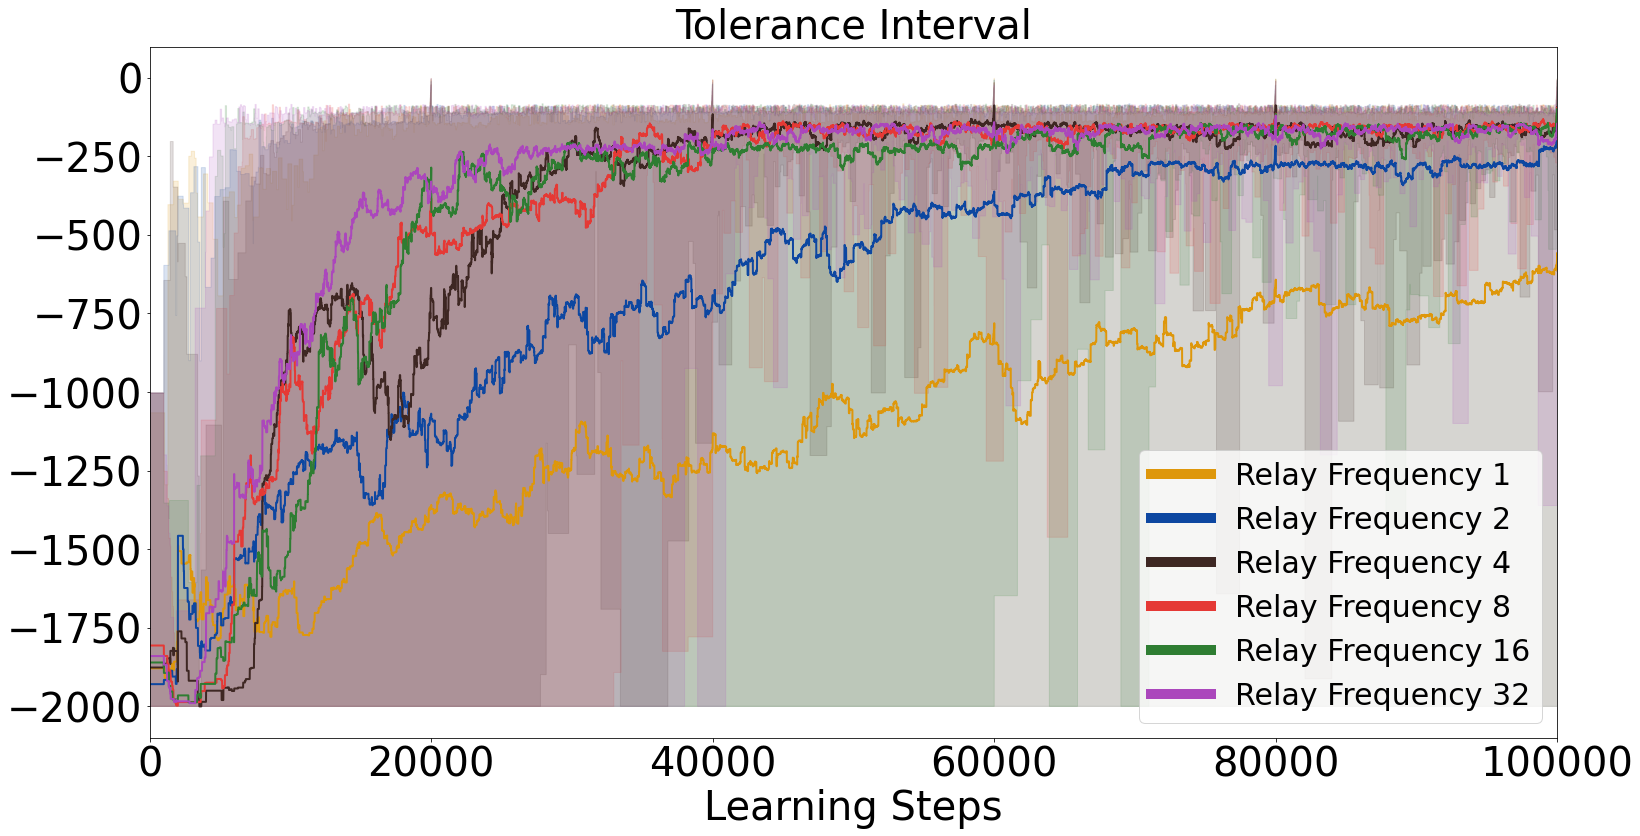

In [22]:
#pdf = matplotlib.backends.backend_pdf.PdfPages("Tolerance Interval_runs_30_for_rf_1_2_4_8_run_15_for_rf_16_32.pdf")
total_runs = 30
pdf = matplotlib.backends.backend_pdf.PdfPages(plots_path + "\Tolerance Interval_runs_"+str(total_runs)+".pdf")
fig, ax = plt.subplots(figsize=(23,12))

for i, replay in enumerate(replay_frequency_list):
    path_file = data_path + "\log_train_rf_" + str(replay) + '.pkl'
    print(path_file)
    log_train = load_path_obj(path_file)
    log_train_EpisodeReturn = log_train[log_train['Metric']=="EpisodeReturns"].reset_index(drop=True)
    #total_runs = np.unique(log_train_EpisodeReturn['Run']).shape[0]
    
    episodic_return = np.zeros((total_runs, total_steps))

    for r in range(total_runs):
        log_train_EpisodeReturn_PerRun = log_train_EpisodeReturn[log_train_EpisodeReturn['Run']==r+1].reset_index(drop=True)
        single_run_history = np.zeros(total_steps)
        previous_position = 0

        for e in range(log_train_EpisodeReturn_PerRun['Run'].shape[0]):
            temp = np.full((1, log_train_EpisodeReturn_PerRun['Step'][e] - previous_position), log_train_EpisodeReturn_PerRun['Undiscount_Return'][e])

            np.put(single_run_history, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e]),temp)
            previous_position = log_train_EpisodeReturn_PerRun['Step'][e]

        #np.put(episodic_return, range(previous_position, log_train_EpisodeReturn_PerRun['Step'][e+1]),temp)
        #print('before')
        #print(episodic_return)
        episodic_return[r]= single_run_history
        #print('after')
        #print(episodic_return[r])
        
        

    #tolerance Interval
    low_ti,mean_ti, high_ti = toleranceIntervalOverCurve (episodic_return)

    p1 = ax.fill_between(range(low_ti.shape[0]), low_ti, high_ti, color = col[i], alpha=0.15)
    p2 = ax.plot(range(low_ti.shape[0]), mean_ti, linewidth=2, color = col[i], label ='Relay Frequency '+ str(replay) )



legend = plt.legend(loc=4,prop={'size': fsize},frameon=True)
legend_elements = [Line2D([0],[0],markersize=10,color=col[0],label='Relay Frequency 1', lw=10),
                   Line2D([0],[0],markersize=12,color=col[1],label='Relay Frequency 2', lw=10),
                   Line2D([0],[0],markersize=12,color=col[2],label='Relay Frequency 4', lw=10),
                   Line2D([0],[0],markersize=12,color=col[3],label='Relay Frequency 8', lw=10),
                   Line2D([0],[0],markersize=12,color=col[4],label='Relay Frequency 16', lw=10),
                   Line2D([0],[0],markersize=12,color=col[5],label='Relay Frequency 32', lw=10)]


ax.legend(handles=legend_elements,loc=4, prop={'size': 30})

#ax.legend(custom_lines)
plt.title('Tolerance Interval',size = fsize)
#plt.xlabel("X axis label")
plt.xlabel("Learning Steps",size = fsize)
plt.tight_layout()
plt.subplots_adjust(left=0.10, right=0.95, top=0.9, bottom=0.1)
plt.xticks(size = fsize)
plt.yticks(size = fsize)
plt.xlim([0, 100000])
plt.show()

plt.close()
pdf.savefig(fig )
pdf.close()